# Multinomial classification with MNIST


## Libraries

In [1]:
# libraries
#using Flux              # the julia ml library
using Images            # image processing and machine vision for julia
using MLJ               # make_blobs, rmse, confmat, f1score, coerce
using MLDataUtils       # label, nlabel, labelfreq
using MLDatasets        # mnist

#using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
#using Distributions

using Plots; gr()
#using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(f1score(ŷ, y);  digits=3))
end


printMetrics (generic function with 1 method)

In [11]:
# lib functions
image2Vector(M) = vec(Float64.(M))

function batchImage2Vector(imagesArray3D)
    h, v, N = size(imagesArray3D)
    vectorOfImageVectors = [ image2Vector( imagesArray3D[:, :, i] ) for i in 1:N]
end

function batchImage2DF(imagesArray3D)
    vectorOfImageVectors = batchImage2Vector(imagesArray3D)
    M = reduce(hcat, vectorOfImageVectors)
    DataFrame(M', :auto)
end


batchImage2DF (generic function with 1 method)

## Loading the data

,,,,

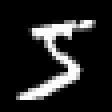
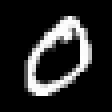
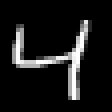
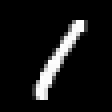
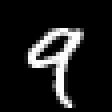

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [4]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [44]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Data preprocessing

Data preprocessing depends on the data source, thus can widely vary from what is shown here.

In [45]:
function preprocessing(X, y)
    newX = batchImage2DF(X)
    #coerce!(newX)   # no need, all scitypes are Continuous in this example
    
    new_y = coerce(y, OrderedFactor)
    
    return (newX, new_y)
end

X, y = preprocessing(trainX, trainY);

In [47]:
scitype(X)

Table{AbstractVector{Continuous}}

In [41]:
scitype(y)

AbstractVector{OrderedFactor{10}} (alias for AbstractArray{OrderedFactor{10}, 1})

## Training, Testing, Validation

### Load the algorithm

In [52]:
MultinomialClassifier = @load MultinomialClassifier pkg=MLJLinearModels verbosity=0

MLJLinearModels.MultinomialClassifier

### Instantiate the model


In [53]:
model = MultinomialClassifier()

MultinomialClassifier(
    lambda = 1.0,
    gamma = 0.0,
    penalty = :l2,
    fit_intercept = true,
    penalize_intercept = false,
    scale_penalty_with_samples = true,
    solver = nothing)

### Creates a machine


In [61]:
mach = MLJ.machine(model, X, y)

Machine{MultinomialClassifier,…} trained 0 times; caches data
  model: MLJLinearModels.MultinomialClassifier
  args: 
    1:	Source @983 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @597 ⏎ `AbstractVector{OrderedFactor{10}}`


### Train the machine


In [63]:
fit!(mach,
    #acceleration = CPUThreads(),   # https://alan-turing-institute.github.io/MLJ.jl/v0.7/acceleration_and_parallelism/
    verbosity=1)

┌ Info: Training Machine{MultinomialClassifier,…}.
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:464
┌ Error: Problem fitting the machine Machine{MultinomialClassifier,…}. 
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:594
┌ Info: Running type checks... 
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:600
┌ Info: Type checks okay. 
└ @ MLJBase /home/ciro/.julia/packages/MLJBase/CglMw/src/machines.jl:603


LoadError: InterruptException:

### Predict an outcome


### Tune the hyper-parameters

When this particular model was instantiated above, one can see that the hyper-parameter "Lambda" could be of relevance to improve the model. Let's tune it as an attempt to minimize the cross-entropy loss and maximize accuracy.

First, we define the parameter and limits to scan:

Then, we define a 10-fold cross-validation, and capture the range parameter(lambdas) and the cross-entropy losses vectors (losses). The first two parameters of the tuple out of the function "learning_curve" are not relevent for this example, so are ignored:

As seen on the chart above, the best tuning parameter is:

### Retrain with best tuning parameter

(in progress)

### Evaluate

(in progress)

### Testing

### Validation